<a href="https://colab.research.google.com/github/otausendschoen/Image_Classification_Diffusion-Augmentation/blob/main/Codes/Copy_of_01_diffusion_model_training_checkpoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EUROSAT Diffusion

### Envrionment Set Up

In [5]:
!pip install -U diffusers[training] #in case collab resets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from huggingface_hub import notebook_login

notebook_login()

!sudo apt -qq install git-lfs
!git config --global credential.helper store

git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Loading the Dataset

In [1]:
from datasets import load_dataset
#this takes about 10 minutes don't worry
dataset = load_dataset(
    "imagefolder",
    data_dir="/content/drive/MyDrive/Thesis_Data/data/eurosat-dataset/6/EuroSAT",
)

print(dataset)


Resolving data files:   0%|          | 0/27000 [00:00<?, ?it/s]

Computing checksums:  94%|#########3| 25317/27000 [00:05<00:00, 5063.22it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})


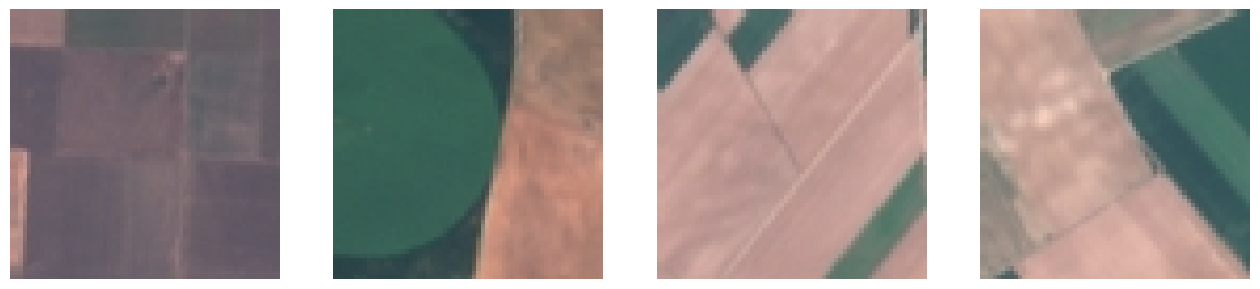

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][:4]["image"]):  # Access images from the train set
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

### Preprocessing for Diffusion

In [3]:
from torchvision import transforms

preprocess_diffusion = transforms.Compose([
    #transforms.Resize((256, 256)), #model input unet
    #transforms.CenterCrop(256),
    transforms.ToTensor(), #pytorch tensor for training
    transforms.Normalize([0.5], [0.5]) #normalization
])

def transform(examples):
    images = [preprocess_diffusion(image.convert("RGB")) for image in examples["image"]]
    labels = examples["label"]  # <- Keep the labels
    return {"images": images, "label": labels}
# Apply the batch transform to your dataset
dataset.set_transform(transform)

In [4]:
print(dataset["train"][0])

{'images': tensor([[[ 0.1686,  0.1686,  0.1608,  ..., -0.2000, -0.1843, -0.1922],
         [ 0.1686,  0.1686,  0.1608,  ..., -0.2000, -0.1843, -0.1922],
         [ 0.1216,  0.1137,  0.1451,  ..., -0.2000, -0.2000, -0.1922],
         ...,
         [ 0.1294,  0.1059,  0.0745,  ..., -0.1922, -0.2157, -0.2078],
         [ 0.0353,  0.0353, -0.0039,  ..., -0.1765, -0.1765, -0.1608],
         [-0.0275, -0.0431, -0.0588,  ..., -0.1686, -0.1686, -0.1608]],

        [[-0.0510, -0.0510, -0.0667,  ..., -0.2941, -0.2784, -0.2863],
         [-0.0510, -0.0510, -0.0667,  ..., -0.2941, -0.2784, -0.2863],
         [-0.0824, -0.0902, -0.0824,  ..., -0.2784, -0.2941, -0.2863],
         ...,
         [-0.0902, -0.0824, -0.0824,  ..., -0.2706, -0.2941, -0.2863],
         [-0.1373, -0.1216, -0.1373,  ..., -0.2627, -0.2706, -0.2549],
         [-0.1765, -0.1686, -0.1922,  ..., -0.2549, -0.2627, -0.2549]],

        [[-0.0588, -0.0588, -0.0510,  ..., -0.2157, -0.2000, -0.2078],
         [-0.0588, -0.0588, -0.051

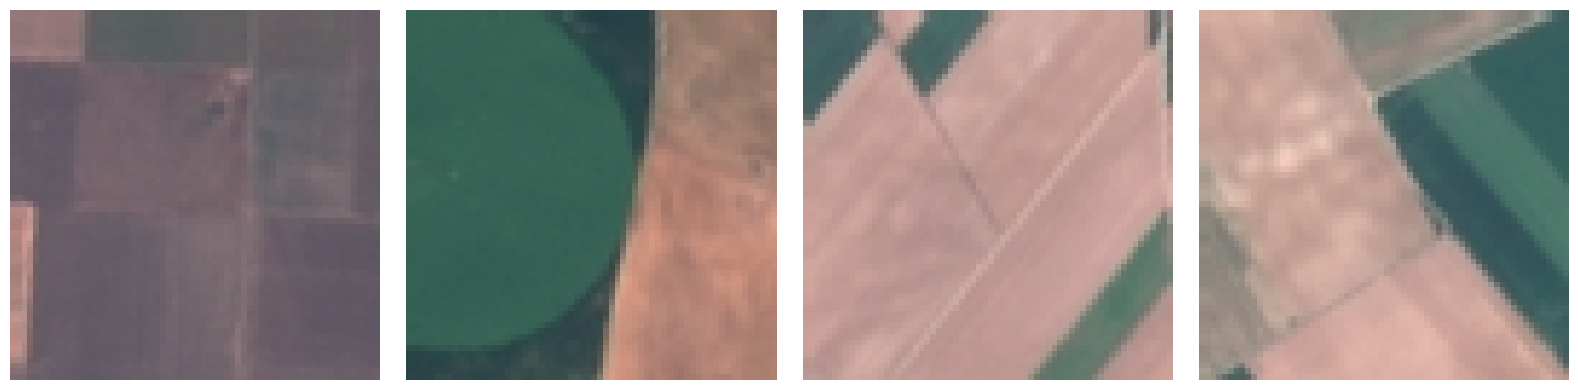

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Load the first 4 samples (batch) from the dataset
batch = dataset["train"][:4]

for i, image in enumerate(batch["images"]):
    # Reverse normalization for display: [-1, 1] → [0, 1]
    image = image.permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
    image = (image * 0.5) + 0.5 #reverse normalization

    axs[i].imshow(image)
    axs[i].set_axis_off()

fig.tight_layout()
plt.show()

## Configuration and Dataloader

In [6]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 64  # the generated image resolution
    train_batch_size = 48
    eval_batch_size = 48  # how many images to sample during evaluation
    num_epochs = 10
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 50
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddpm-eurosat-conditional'  # the model namy locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [7]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

## Defining the model

In [8]:
import torch.nn as nn

#num_classes = 10

In [9]:
from diffusers import UNet2DModel
#from diffusers import UNet2DConditionModel


model = UNet2DModel( #CHANGE TO UNet2DModel FOR UNCONDITIONAL
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
    num_class_embeds=10,  # number of classes (e.g., 10 for EuroSAT) COMMENT THIS OUT FOR UNCONDITIONAL
)

In [ ]:
#sample_image = dataset["train"][0]["images"].unsqueeze(0)  # ✅ Correct for your dataset
#print("Input shape:", sample_image.shape)  # Should print (1, 3, 128, 128)

#And let's check the output is a tensor of the same exact shape:
#print('Output shape:', model(sample_image, timestep=0).sample.shape)

## Defining the noise scheduler

In [10]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)



In [11]:
print(dataset['train'])  # if you have a 'train' split

Dataset({
    features: ['image', 'label'],
    num_rows: 27000
})


## Training

In [12]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)


In [13]:

from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [15]:
#WRAPPING IT ALL UP:
import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration
from huggingface_hub import create_repo, upload_folder

from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    logging_dir = os.path.join(config.output_dir, "logs")
    accelerator_project_config = ProjectConfiguration(project_dir=config.output_dir, logging_dir=logging_dir)
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_config=accelerator_project_config,
    )

    # Save original batch size before preparation
    original_batch_size = config.train_batch_size  # Use this if batch size is in config
    if accelerator.is_main_process:
        repo_id = None  # ← Always define repo_id first

        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=Path(config.output_dir).name, exist_ok=True
            ).repo_id
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
    #if accelerator.is_main_process:
    #    if config.push_to_hub:
    #        repo_id = create_repo(
    #            repo_id=Path(config.output_dir).name, exist_ok=True
    #        ).repo_id
    #    elif config.output_dir is not None:
    #        os.makedirs(config.output_dir, exist_ok=True)
    #    accelerator.init_trackers("train_example")

    # Prepare everything
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0
    # Track losses for plotting
    epoch_losses = []

    # Print training configuration
    if accelerator.is_main_process:
        print(f"  Starting training with the following configuration:")
        print(f"   - Number of epochs: {config.num_epochs}")
        print(f"   - Batch size: {original_batch_size}")  # Use the saved batch size
        print(f"   - Mixed precision: {config.mixed_precision}")
        print(f"   - Gradient accumulation steps: {config.gradient_accumulation_steps}")
        print(f"   - Output directory: {config.output_dir}")
        print(f"   - Device: {accelerator.device}")
        print(f"   - Number of training samples: {len(train_dataloader.dataset)}")

    # Now you train the model
    for epoch in range(config.num_epochs):
        model.train()
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        # Track metrics for this epoch
        epoch_loss = 0.0
        batches_in_epoch = len(train_dataloader)

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            labels = batch['label']  # your class labels
            # Your model must now accept labels
            noise_pred = model(noisy_images, timesteps, class_labels=labels).sample

            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, class_labels=labels, return_dict=False)[0]
                #noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Update metrics
            epoch_loss += loss.detach().item()

            # Update progress bar
            progress_bar.update(1)
            logs = {
                "loss": loss.detach().item(),
                "lr": lr_scheduler.get_last_lr()[0],
                "step": global_step,
                "avg_loss": epoch_loss / (step + 1)
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # End of epoch logging
        avg_epoch_loss = epoch_loss / batches_in_epoch
        epoch_losses.append(avg_epoch_loss)

        if accelerator.is_main_process:
            print(f"\n Epoch {epoch} completed. Average loss: {avg_epoch_loss:.4f}")

            # Plot loss curve periodically
            if (epoch + 1) % 5 == 0 or epoch == config.num_epochs - 1:
                plt.figure(figsize=(10, 6))
                plt.plot(range(len(epoch_losses)), epoch_losses, marker='o')
                plt.title('Training Loss Over Epochs')
                plt.xlabel('Epoch')
                plt.ylabel('Average Loss')
                plt.grid(True)
                loss_plot_path = os.path.join(config.output_dir, f"loss_plot_epoch_{epoch}.png")
                plt.savefig(loss_plot_path)
                plt.close()
                print(f" Loss plot saved to {loss_plot_path}")

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                print(f" Generating sample images for epoch {epoch}...")
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                print(f" Saving model for epoch {epoch}...")
                # Always save the model first
                pipeline.save_pretrained(config.output_dir)

                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                print(f" Model saved successfully!")

New training:

In [19]:
#WRAPPING IT ALL UP:

from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration
from huggingface_hub import create_repo, upload_folder

from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    logging_dir = os.path.join(config.output_dir, "logs")
    accelerator_project_config = ProjectConfiguration(project_dir=config.output_dir, logging_dir=logging_dir)
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_config=accelerator_project_config,
    )

    # Save original batch size before preparation
    original_batch_size = config.train_batch_size  # Use this if batch size is in config
    if accelerator.is_main_process:
        repo_id = None  # ← Always define repo_id first

        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=Path(config.output_dir).name, exist_ok=True
            ).repo_id
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
    #if accelerator.is_main_process:
    #    if config.push_to_hub:
    #        repo_id = create_repo(
    #            repo_id=Path(config.output_dir).name, exist_ok=True
    #        ).repo_id
    #    elif config.output_dir is not None:
    #        os.makedirs(config.output_dir, exist_ok=True)
    #    accelerator.init_trackers("train_example")

    # Prepare everything
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0
    # Track losses for plotting
    epoch_losses = []

    # Print training configuration
    if accelerator.is_main_process:
        print(f"  Starting training with the following configuration:")
        print(f"   - Number of epochs: {config.num_epochs}")
        print(f"   - Batch size: {original_batch_size}")  # Use the saved batch size
        print(f"   - Mixed precision: {config.mixed_precision}")
        print(f"   - Gradient accumulation steps: {config.gradient_accumulation_steps}")
        print(f"   - Output directory: {config.output_dir}")
        print(f"   - Device: {accelerator.device}")
        print(f"   - Number of training samples: {len(train_dataloader.dataset)}")

    # Now you train the model
    for epoch in range(config.num_epochs):
        model.train()
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        # Track metrics for this epoch
        epoch_loss = 0.0
        batches_in_epoch = len(train_dataloader)

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            labels = batch['label']  # your class labels #COMMENT OUT FOR UNCONDITIONAL

            # Your model must now accept labels
            #noise_pred = model(noisy_images, timesteps, class_labels=labels).sample #COMMENT OUT FOR UNCONDITIONAL

            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device) #USE FOR UNCONDITIONAL
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, class_labels=labels, return_dict=False)[0]
                #noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Update metrics
            epoch_loss += loss.detach().item()

            # Update progress bar
            progress_bar.update(1)
            logs = {
                "loss": loss.detach().item(),
                "lr": lr_scheduler.get_last_lr()[0],
                "step": global_step,
                "avg_loss": epoch_loss / (step + 1)
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # End of epoch logging
        avg_epoch_loss = epoch_loss / batches_in_epoch
        epoch_losses.append(avg_epoch_loss)

        if accelerator.is_main_process:
            print(f"\n Epoch {epoch} completed. Average loss: {avg_epoch_loss:.4f}")

            # Plot loss curve periodically
            if (epoch + 1) % 5 == 0 or epoch == config.num_epochs - 1:
                plt.figure(figsize=(10, 6))
                plt.plot(range(len(epoch_losses)), epoch_losses, marker='o')
                plt.title('Training Loss Over Epochs')
                plt.xlabel('Epoch')
                plt.ylabel('Average Loss')
                plt.grid(True)
                loss_plot_path = os.path.join(config.output_dir, f"loss_plot_epoch_{epoch}.png")
                plt.savefig(loss_plot_path)
                plt.close()
                print(f" Loss plot saved to {loss_plot_path}")

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                print(f" Generating sample images for epoch {epoch}...")
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                print(f" Saving model for epoch {epoch}...")
                # Always save the model first
                pipeline.save_pretrained(config.output_dir)

                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                print(f" Model saved successfully!")

new one with checkpoints and mkdir for plot


In [25]:
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from diffusers import DDPMPipeline

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    logging_dir = os.path.join(config.output_dir, "logs")
    accelerator_project_config = ProjectConfiguration(project_dir=config.output_dir, logging_dir=logging_dir)
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_config=accelerator_project_config,
    )

    # Prepare everything (model, optimizer, scheduler, dataloader)
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    if accelerator.is_main_process:
        repo_id = None  # important: always define repo_id

        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=Path(config.output_dir).name, exist_ok=True
            ).repo_id
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)

    global_step = 0
    epoch_losses = []

    # ======================================================
    # 📦 Try to resume from latest checkpoint if available
    latest_checkpoint = None
    output_dir = Path(config.output_dir)
    checkpoints = sorted(output_dir.glob("checkpoint_epoch_*"), key=lambda p: int(p.name.split("_")[-1]))
    if checkpoints:
        latest_checkpoint = checkpoints[-1]

    if latest_checkpoint:
        print(f"Resuming from checkpoint: {latest_checkpoint}")
        accelerator.load_state(str(latest_checkpoint))
    # ======================================================

    if accelerator.is_main_process:
        print(f"  Starting training with the following configuration:")
        print(f"   - Number of epochs: {config.num_epochs}")
        print(f"   - Batch size: {config.train_batch_size}")
        print(f"   - Mixed precision: {config.mixed_precision}")
        print(f"   - Output directory: {config.output_dir}")
        print(f"   - Number of training samples: {len(train_dataloader.dataset)}")

    # 🔥 Start training loop
    for epoch in range(config.num_epochs):
        model.train()
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        epoch_loss = 0.0
        batches_in_epoch = len(train_dataloader)

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            labels = batch['label']

            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device).long()

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, class_labels=labels, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            epoch_loss += loss.detach().item()

            progress_bar.update(1)
            logs = {
                "loss": loss.detach().item(),
                "lr": lr_scheduler.get_last_lr()[0],
                "step": global_step,
                "avg_loss": epoch_loss / (step + 1)
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # End of epoch
        avg_epoch_loss = epoch_loss / batches_in_epoch
        epoch_losses.append(avg_epoch_loss)

        if accelerator.is_main_process:
            print(f"\n Epoch {epoch} completed. Average loss: {avg_epoch_loss:.4f}")

            # ======================
            # 📈 Save loss plot
            if (epoch + 1) % 5 == 0 or epoch == config.num_epochs - 1:
                plt.figure(figsize=(10, 6))
                plt.plot(range(len(epoch_losses)), epoch_losses, marker='o')
                plt.title('Training Loss Over Epochs')
                plt.xlabel('Epoch')
                plt.ylabel('Average Loss')
                plt.grid(True)
                loss_plot_path = os.path.join(config.output_dir, f"loss_plot_epoch_{epoch}.png")
                os.makedirs(os.path.dirname(loss_plot_path), exist_ok=True)  # ✅ Make sure dir exists
                plt.savefig(loss_plot_path)
                plt.close()
                print(f" Loss plot saved to {loss_plot_path}")
            # ======================

            # ======================
            # 🧹 Save full checkpoint (model + optimizer + scheduler)
            if (epoch + 1) % 2 == 0 or epoch == config.num_epochs - 1:
                checkpoint_dir = os.path.join(config.output_dir, f"checkpoint_epoch_{epoch}")
                accelerator.save_state(checkpoint_dir)
                print(f"Checkpoint saved to {checkpoint_dir}")
            # ======================

            # ======================
            # 🖼️ Save generated images
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                print(f" Generating sample images for epoch {epoch}...")
                evaluate(config, epoch, pipeline)
            # ======================

            # ======================
            # 💾 Save full model
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                print(f" Saving model for epoch {epoch}...")
                pipeline.save_pretrained(config.output_dir)

                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                print(f" Model saved successfully!")
            # ======================


## Let's train

In [26]:
from torch.utils.data import DataLoader

# Ensure the "train" split is correctly accessed
train_dataloader = DataLoader(
    dataset["train"],  # Access the 'train' split
    batch_size=config.train_batch_size,  # Set batch size
    shuffle=True
)

print(dataset.keys())  # Check if 'train' exists as a key



dict_keys(['train'])


In [ ]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.
  Starting training with the following configuration:
   - Number of epochs: 10
   - Batch size: 48
   - Mixed precision: fp16
   - Output directory: ddpm-eurosat-conditional
   - Number of training samples: 27000


  0%|          | 0/563 [00:00<?, ?it/s]